## Importing the Dependencies

In [1]:
import numpy as np , pandas as pd , cv2, os, seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , precision_score , recall_score , f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, MaxPooling2D
from sklearn.model_selection import cross_val_score
from scipy.ndimage import rotate
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models

## Wrangling Data

In [2]:
# Initialize an empty list to Forniceal Palpebral images
Forniceal_Palpebral_images_italy = []
for i in range(1, 124):
    folder_name_2 = str(i).zfill(3)  
    img_i_path = rf'C:\Italy\{i}\{folder_name_2}_forniceal_palpebral.png' 
    img_i = cv2.imread(img_i_path, cv2.IMREAD_GRAYSCALE)
    Forniceal_Palpebral_images_italy.append(img_i)    
    
Forniceal_Palpebral_images_india = []
for i in range(1, 96):
    folder_name_2 = str(i).zfill(3)  
    img_i_path = rf'C:\India\{i}\{folder_name_2}_forniceal_palpebral.png' 
    img_i = cv2.imread(img_i_path, cv2.IMREAD_GRAYSCALE)
    Forniceal_Palpebral_images_india.append(img_i) 
    
Forniceal_Palpebral_images = Forniceal_Palpebral_images_italy + Forniceal_Palpebral_images_india

In [3]:
# Initialize an empty list to Palpebral images
Palpebral_images_italy = []
for i in range(1, 124):
    folder_name_3 = str(i).zfill(3)  
    img_i_path = rf'C:\Italy\{i}\{folder_name_3}_palpebral.png' 
    img_i = cv2.imread(img_i_path, cv2.IMREAD_GRAYSCALE)
    Palpebral_images_italy.append(img_i)
    
Palpebral_images_india = []
for i in range(1, 96):
    folder_name_3 = str(i).zfill(3)  
    img_i_path = rf'C:\India\{i}\{folder_name_3}_palpebral.png' 
    img_i = cv2.imread(img_i_path, cv2.IMREAD_GRAYSCALE)
    Palpebral_images_india.append(img_i)
    
Palpebral_images = Palpebral_images_italy + Palpebral_images_india

In [4]:
file_path_india = 'C:\India\India.xlsx'
df_india = pd.read_excel(file_path_india)
file_path_italy = 'C:\Italy\Italy.xlsx'
df_italy = pd.read_excel(file_path_italy)

In [5]:
df_anemic = pd.concat([df_italy['Hgb'], df_india['Hgb']], ignore_index=True, axis=0)

In [6]:
df_anemic.head()

0     9.3
1    10.2
2    10.7
3    11.7
4    11.6
Name: Hgb, dtype: float64

In [7]:
print(Forniceal_Palpebral_images_italy[5].shape)

(1067, 800)


## Preprocessing 

* Whole Conjunctiva & Palpebral Data

In [8]:
# Define indices of missing values to remove
indices_to_remove = [0, 34, 53, 57, 74, 108]
# Remove elements at the specified indices from images
Forniceal_Palpebral_images = [img for idx, img in enumerate(Forniceal_Palpebral_images) if idx not in indices_to_remove]
Palpebral_images = [img for idx, img in enumerate(Palpebral_images) if idx not in indices_to_remove]

In [9]:
for i in range(len(Forniceal_Palpebral_images)):
    Forniceal_Palpebral_images[i] = Forniceal_Palpebral_images[i] / 255.0

In [10]:
for i in range(len(Palpebral_images)):
    Palpebral_images[i] = Palpebral_images[i] / 255.0

In [11]:
Forniceal_Palpebral_images_normalized = np.array(Forniceal_Palpebral_images)
Palpebral_images_normalized = np.array(Palpebral_images)

In [12]:
# Resize images
new_width = 200  
new_height = 150 

Forniceal_Palpebral_images_resized = []
for image in Forniceal_Palpebral_images_normalized:
    resized_image = cv2.resize(image, (new_width, new_height))
    Forniceal_Palpebral_images_resized.append(resized_image)
    
Palpebral_images_resized = []
for image in Palpebral_images_normalized:
    resized_image = cv2.resize(image, (new_width, new_height))
    Palpebral_images_resized.append(resized_image)

* Hgb Target Data

In [13]:
rows_to_remove = [0, 34, 53, 57, 74, 108]
# Remove rows with specified indices from df_anemic
df_anemic = df_anemic.drop(rows_to_remove)

In [14]:
anemia_threshold = 10.5  # Threshold for anemia (Hgb levels below this indicate anemia)
# Function to classify anemia based on Hgb levels
def classify_anemia(Hgb):
    if Hgb <= anemia_threshold:
        return 1
    else:
        return 0
# Apply the function to classify anemia status for each individual
df_anemic['Anemia_Status_label'] = df_anemic.apply(classify_anemia)

In [15]:
df_anemic['Anemia_Status_label'].value_counts()

Hgb
0    170
1     42
Name: count, dtype: int64

## Feature Extraction

* LeNet-5

In [16]:
# Building the model 
LeNet_5 = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(new_height, new_width, 1)),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax') 
])

# feature extraction
features_whole = LeNet_5.predict(np.array(Forniceal_Palpebral_images_resized))
features_Palpebral = LeNet_5.predict(np.array(Palpebral_images_resized))

# Flatten the features
flattened_features_whole = features_whole.reshape(features_whole.shape[0], -1)
flattened_features_palpebral = features_Palpebral.reshape(features_Palpebral.shape[0], -1)

7/7 [==============================] - 0s 61ms/step


In [17]:
LeNet_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 196, 6)       156       
                                                                 
 average_pooling2d (Average  (None, 73, 98, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 94, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 34, 47, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 25568)             0         
                                                                 
 dense (Dense)               (None, 120)               3

In [42]:
print(len(flattened_features_whole))

212


In [43]:
print(len(flattened_features_palpebral))

212


## Spliting Data

In [18]:
y = df_anemic['Anemia_Status_label']

## Train Test Split

In [19]:
x_train_whole, x_test_whole, y_train, y_test = train_test_split(flattened_features_whole, y, test_size=0.4, random_state=42)

In [20]:
x_train_Palpebral, x_test_Palpebral, y_train, y_test = train_test_split(flattened_features_palpebral, y, test_size=0.4, random_state=42)

## RusBoost

In [21]:
rusboost_clf = RUSBoostClassifier(n_estimators=50, random_state=42)

* Whole Conjunctiva

In [22]:
# Train the classifier on whole conjunctiva 
rusboost_clf.fit(x_train_whole, y_train)

RUSBoostClassifier(random_state=42)

In [23]:
# Predict on the training set
y_train_pred = rusboost_clf.predict(x_train_whole)

* Evaluation on Whole Conjunctiva 

In [50]:
# Evaluate the classifier on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy on Whole Conjunctiva:", train_accuracy)

Training Accuracy on Whole Conjunctiva: 0.9448818897637795


In [83]:
# precision_score for training data
precision_train = precision_score(y_train,y_train_pred)
print('Training Precision on Whole Conjunctiva:',precision_train)

Training Precision on Whole Conjunctiva: 0.8484848484848485


In [84]:
# recall_score for training data
recall_score_train = recall_score(y_train,y_train_pred)
print('Training Recall on Whole Conjunctiva:',recall_score_train)

Training Recall on Whole Conjunctiva: 0.9333333333333333


In [85]:
# f1_score for training data
f1_score_train = f1_score(y_train,y_train_pred)
print('Training F1 Score on Whole Conjunctiva:',f1_score_train)

Training F1 Score on Whole Conjunctiva: 0.888888888888889


In [56]:
# Predict on the test set
y_test_pred = rusboost_clf.predict(x_test_whole)

In [60]:
# Evaluate the classifier
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy on Whole Conjunctiva:", test_accuracy)

Testing Accuracy on Whole Conjunctiva: 0.7176470588235294


* Palpebral Conjunctiva 

In [24]:
# Train the classifier on palpebral conjunctiva 
rusboost_clf.fit(x_train_Palpebral, y_train)

RUSBoostClassifier(random_state=42)

In [25]:
# Predict on the training set
y_train_pred = rusboost_clf.predict(x_train_Palpebral)

* Evaluation on Palpebral Conjunctiva 

In [82]:
# Evaluate the classifier on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy on Palpebral Conjunctiva:", train_accuracy)

Training Accuracy on Palpebral Conjunctiva: 0.968503937007874


In [26]:
# precision_score for training data
precision_train_palpebral = precision_score(y_train, y_train_pred)
print('Training Precision on Palpebral Conjunctiva:',precision_train_palpebral)

Training Precision on Palpebral Conjunctiva: 0.8285714285714286


In [100]:
# recall_score for training data
recall_train_palpebral = recall_score(y_train,y_train_pred)
print('Training Recall on Palpebral Conjunctiva:',recall_score_train)

Training Recall on Palpebral Conjunctiva: 0.9333333333333333


In [101]:
# f1_score for training data
f1_score_train_palpebral = f1_score(y_train,y_train_pred)
print('Training F1 Score on Palpebral Conjunctiva:',f1_score_train)

Training F1 Score on Palpebral Conjunctiva: 0.888888888888889


In [104]:
# Predict on the test set
y_test_pred = rusboost_clf.predict(x_test_Palpebral)

In [108]:
# Evaluate the classifier
test_accuracy_palpebral = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy on Palpebral Conjunctiva:", test_accuracy_palpebral)

Testing Accuracy on Palpebral Conjunctiva: 0.7411764705882353


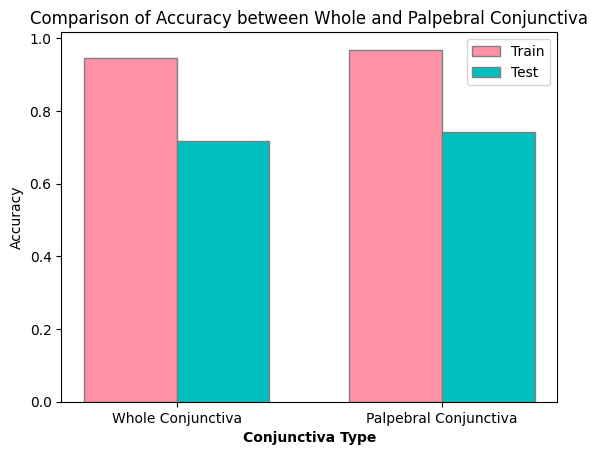

In [8]:
# Labels for the bars
labels = ['Train Accuracy', 'Test Accuracy']
# Values for the bars
train_values = [train_accuracy_whole, train_accuracy_palpebral]
test_values = [test_accuracy, test_accuracy_palpebral]
# Width of the bars
bar_width = 0.35
# Set the positions of the bars on the x-axis
r1 = range(len(labels))
r2 = [x + bar_width for x in r1]
# Create the bar plot
plt.bar(r1, train_values, color='#FF91A4', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, test_values, color='c', width=bar_width, edgecolor='grey', label='Test')
# Add labels and title
plt.xlabel('Conjunctiva Type', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(labels))], ['Whole Conjunctiva', 'Palpebral Conjunctiva'])
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy between Whole and Palpebral Conjunctiva')
# Add legend
plt.legend()
# Show plot
plt.show()

## Data Augmentation

In [16]:
# Define the data augmentation functions
def rotate_image(image, angle):
    rows, cols = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return rotated_image

def flip_image(image, flip_code):
    flipped_image = cv2.flip(image, flip_code)
    return flipped_image

def scale_image(image, scale_factor):
    scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    return scaled_image

def translate_image(image, dx, dy):
    rows, cols = image.shape
    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return translated_image

# Define the data augmentation parameters
rotation_angles = [90, 180, 270]
flip_codes = [0, 1, -1]  
scale_factors = [0.8, 1.2]  
translations = [(10, 10), (-10, -10)]  

* Whole Conjunctiva

In [17]:
# Define desired dimensions
desired_width = 200
desired_height = 150
# Perform data augmentation
augmented_whole_images = []
augmented_labels = []
for idx, image in enumerate(Forniceal_Palpebral_images_resized):
    label = df_anemic['Anemia_Status_label'].iloc[idx]
    # Resize the image to desired dimensions
    image = cv2.resize(image, (desired_width, desired_height))
    # Original image
    augmented_whole_images.append(image)
    augmented_labels.append(label)   
    # Augmentations
    for angle in rotation_angles:
        rotated_image = rotate_image(image, angle)
        # Resize the rotated image
        rotated_image = cv2.resize(rotated_image, (desired_width, desired_height))
        augmented_whole_images.append(rotated_image)
        augmented_labels.append(label)    
    for flip_code in flip_codes:
        flipped_image = flip_image(image, flip_code)
        # Resize the flipped image
        flipped_image = cv2.resize(flipped_image, (desired_width, desired_height))
        augmented_whole_images.append(flipped_image)
        augmented_labels.append(label)    
    for scale_factor in scale_factors:
        scaled_image = scale_image(image, scale_factor)
        # Resize the scaled image
        scaled_image = cv2.resize(scaled_image, (desired_width, desired_height))
        augmented_whole_images.append(scaled_image)
        augmented_labels.append(label)   
    for translation in translations:
        translated_image = translate_image(image, translation[0], translation[1])
        # Resize the translated image
        translated_image = cv2.resize(translated_image, (desired_width, desired_height))
        augmented_whole_images.append(translated_image)
        augmented_labels.append(label)

In [18]:
print(len(augmented_whole_images))

2332


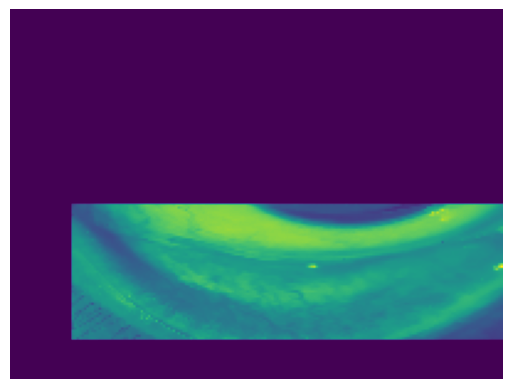

In [19]:
plt.imshow(augmented_whole_images[2000])
plt.axis('off') 
plt.show()

In [20]:
print(augmented_whole_images[2000].shape)

(150, 200)


In [21]:
print(augmented_whole_images[2000])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
augmented_labels_s = pd.Series(augmented_labels)
augmented_labels_s.value_counts()

0    1870
1     462
Name: count, dtype: int64

In [23]:
# Convert to numpy arrays
augmented_images = np.array(augmented_whole_images)
augmented_labels = np.array(augmented_labels)

In [24]:
augmented_whole_images = np.expand_dims(augmented_whole_images, axis=-1)

In [25]:
x_train_1,x_test_1,y_train,y_test = train_test_split(augmented_whole_images, augmented_labels, test_size=0.2, random_state=42)

* Palpebral Conjunctiva

In [26]:
# Define desired dimensions
desired_width = 200
desired_height = 150
# Perform data augmentation
augmented_palpebral_images = []
augmented_labels = []
for idx, image in enumerate(Palpebral_images_resized):
    label = df_anemic['Anemia_Status_label'].iloc[idx]
    # Resize the image to desired dimensions
    image = cv2.resize(image, (desired_width, desired_height))
    # Original image
    augmented_palpebral_images.append(image)
    augmented_labels.append(label)   
    # Augmentations
    for angle in rotation_angles:
        rotated_image = rotate_image(image, angle)
        # Resize the rotated image
        rotated_image = cv2.resize(rotated_image, (desired_width, desired_height))
        augmented_palpebral_images.append(rotated_image)
        augmented_labels.append(label)    
    for flip_code in flip_codes:
        flipped_image = flip_image(image, flip_code)
        # Resize the flipped image
        flipped_image = cv2.resize(flipped_image, (desired_width, desired_height))
        augmented_palpebral_images.append(flipped_image)
        augmented_labels.append(label)    
    for scale_factor in scale_factors:
        scaled_image = scale_image(image, scale_factor)
        # Resize the scaled image
        scaled_image = cv2.resize(scaled_image, (desired_width, desired_height))
        augmented_palpebral_images.append(scaled_image)
        augmented_labels.append(label)   
    for translation in translations:
        translated_image = translate_image(image, translation[0], translation[1])
        # Resize the translated image
        translated_image = cv2.resize(translated_image, (desired_width, desired_height))
        augmented_palpebral_images.append(translated_image)
        augmented_labels.append(label)

In [27]:
# Convert to numpy arrays
augmented_palpebral_images = np.array(augmented_palpebral_images)
augmented_labels = np.array(augmented_labels)

In [28]:
augmented_palpebral_images = np.expand_dims(augmented_palpebral_images, axis=-1)

In [29]:
x_train_2,x_test_2,y_train,y_test = train_test_split(augmented_palpebral_images, augmented_labels, test_size=0.2, random_state=42)

## Building CNN Model

* Whole Conjunctiva

In [27]:
# Define CNN architecture
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Define input shape for CNN
input_shape = augmented_whole_images[0].shape  # Shape of augmented images
# Define CNN model
cnn_model = create_cnn(input_shape)

In [28]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Train the model
history_whole = cnn_model.fit(x_train_1, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
47/47 [==============================] - 56s 1s/step - loss: 0.5754 - accuracy: 0.7929 - val_loss: 0.4530 - val_accuracy: 0.8311
Epoch 2/15
47/47 [==============================] - 54s 1s/step - loss: 0.4677 - accuracy: 0.8009 - val_loss: 0.4787 - val_accuracy: 0.8311
Epoch 3/15
47/47 [==============================] - 58s 1s/step - loss: 0.4390 - accuracy: 0.8009 - val_loss: 0.4946 - val_accuracy: 0.8311
Epoch 4/15
47/47 [==============================] - 52s 1s/step - loss: 0.4136 - accuracy: 0.8009 - val_loss: 0.4850 - val_accuracy: 0.8311
Epoch 5/15
47/47 [==============================] - 52s 1s/step - loss: 0.3862 - accuracy: 0.8016 - val_loss: 0.4694 - val_accuracy: 0.8338
Epoch 6/15
47/47 [==============================] - 59s 1s/step - loss: 0.3560 - accuracy: 0.8123 - val_loss: 0.4918 - val_accuracy: 0.8365
Epoch 7/15
47/47 [==============================] - 53s 1s/step - loss: 0.3317 - accuracy: 0.8204 - val_loss: 0.5226 - val_accuracy: 0.7989
Epoch 8/15
47/47 [==

In [30]:
# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(x_test_1, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 4s 251ms/step - loss: 0.7871 - accuracy: 0.8051
Test Loss: 0.7871370911598206
Test Accuracy: 0.8051391839981079


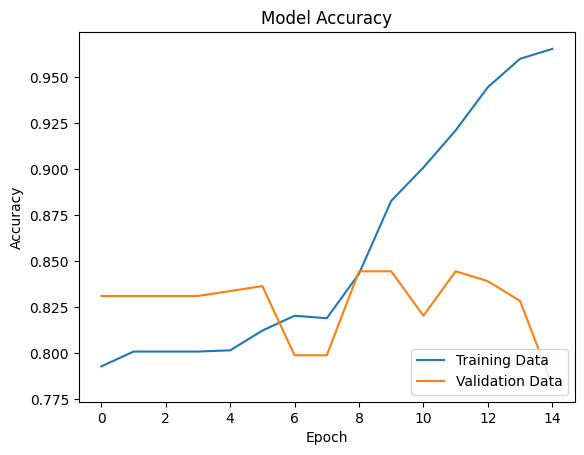

In [33]:
# Visualize accuracy and loss
plt.plot(history_whole.history['accuracy'])
plt.plot(history_whole.history['val_accuracy'])
plt.title('CNN on Whole Conjunctiva Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Data','Validation Data'], loc = 'lower right')

* Palpebral Conjunctiva

In [38]:
# Define CNN architecture
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Define input shape for CNN
input_shape = augmented_palpebral_images[0].shape  
# Define CNN model
cnn_model = create_cnn(input_shape)

In [39]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Train the model
history_palpebral = cnn_model.fit(x_train_2, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
47/47 [==============================] - 57s 1s/step - loss: 0.5483 - accuracy: 0.7936 - val_loss: 0.4440 - val_accuracy: 0.8311
Epoch 2/15
47/47 [==============================] - 54s 1s/step - loss: 0.4615 - accuracy: 0.7996 - val_loss: 0.4619 - val_accuracy: 0.8016
Epoch 3/15
47/47 [==============================] - 51s 1s/step - loss: 0.4153 - accuracy: 0.8063 - val_loss: 0.4334 - val_accuracy: 0.8231
Epoch 4/15
47/47 [==============================] - 53s 1s/step - loss: 0.3609 - accuracy: 0.8271 - val_loss: 0.4320 - val_accuracy: 0.8177
Epoch 5/15
47/47 [==============================] - 54s 1s/step - loss: 0.3037 - accuracy: 0.8532 - val_loss: 0.4432 - val_accuracy: 0.8472
Epoch 6/15
47/47 [==============================] - 54s 1s/step - loss: 0.2383 - accuracy: 0.8948 - val_loss: 0.5919 - val_accuracy: 0.8311
Epoch 7/15
47/47 [==============================] - 53s 1s/step - loss: 0.1832 - accuracy: 0.9223 - val_loss: 0.4626 - val_accuracy: 0.8660
Epoch 8/15
47/47 [==

In [41]:
# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(x_test_2, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 4s 243ms/step - loss: 0.9969 - accuracy: 0.8351
Test Loss: 0.9968511462211609
Test Accuracy: 0.835117757320404


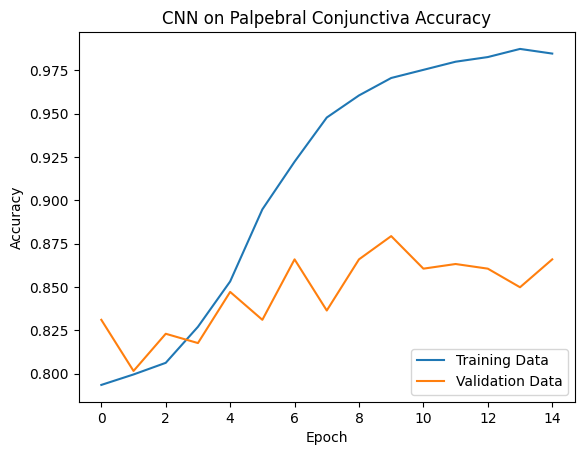

In [42]:
# Visualize accuracy and loss
plt.plot(history_palpebral.history['accuracy'])
plt.plot(history_palpebral.history['val_accuracy'])
plt.title('CNN on Palpebral Conjunctiva Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Data','Validation Data'], loc = 'lower right')